In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from shutil import copyfile, move

import glob
import time
import os

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras.utils import to_categorical

from numba import cuda

In [2]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

In [3]:
import numpy as np

In [4]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

In [5]:
batch_size = 32
img_height = 80
img_width = 1024
SHUFFLE_BUFFER_SIZE = 100
data_dir = './spectrogramImgs/'
# data_dir = pathlib.Path(data_dir)

num_classes = 11
epochs = 100
patience = 30
sampling_rate = 100
NOW = datetime.now().strftime("%Y%m%d-%H%M%S")
seq_frame_len = 40
learning_rate = 0.001
# data_dir = pathlib.Path(data_dir)

def getImgNp(uri):
    img = np.array(PIL.Image.open(str(uri)));
#     print(img.shape)
    img = img.flatten()
#     print(img.shape)
    return img #.reshape(1,1024)
def spectrogramImage(directory):
    uris = sorted(glob.glob( directory + '*.png'))
    imgs = []
    for i, uri in enumerate(uris):
        img = getImgNp(uri)
#         print(img.shape)
#         plt.imshow(img)
        imgs.append(img)
#     img /= len(uris)
    imgs = np.array(imgs)
#     print(imgs.shape)
    return imgs

def averageImageAndSave(dirsArray, dest):
    for directory in dirsArray:
        img = spectrogramImage(directory) 
def averageImage(directory):
#     for directory in dirsArray:
    img = spectrogramImage(directory)
#         break;
    return img
#     plt.imsave('./dataset/spectrogramImgs/' + dest + '/' + str(time.time()) + '.png', img)

model_id = '{}_c{}b{}e{}p{}l{}s{}_{}'.format('sq', num_classes, batch_size, epochs, patience, seq_frame_len, sampling_rate, NOW)


In [6]:
x = []
y = []
train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
for dataset in [train, test]:
    for element in dataset.as_numpy_iterator():
#     print(element[0].shape)
        for img in element[0]:
            x.append(img)
        for label in element[1]:
            y.append(label)

Found 9478 files belonging to 11 classes.
Using 6635 files for training.
Found 9478 files belonging to 11 classes.
Using 2843 files for validation.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123, stratify=y)
# Don't use the testing partition for validation. Instead, create a smaller partition.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.28, random_state=123, stratify=y_train)


In [8]:
X_train = np.array(X_train)
y_train = to_categorical(np.array(y_train)).astype(np.int32)

X_test = np.array(X_test)
y_test = to_categorical(np.array(y_test)).astype(np.int32)

X_valid = np.array(X_valid)
y_valid = to_categorical(np.array(y_valid)).astype(np.int32)

In [9]:
print(X_valid.shape)
print(X_train.shape)
print(X_test.shape)

(1858, 80, 1024, 3)
(4776, 80, 1024, 3)
(2844, 80, 1024, 3)


In [10]:
visualizer = tf.keras.callbacks.TensorBoard(log_dir='./spectro/tfevents_{}'.format(model_id))
earlystops = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, verbose=0)

In [11]:
# constructing tf dataset
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
val = val.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test = test.batch(batch_size)

In [12]:
num_classes = 11

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='LeakyReLU'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='LeakyReLU'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='LeakyReLU'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='LeakyReLU'),
  layers.MaxPooling2D(),
  layers.Flatten(),
#   layers.Dense(2048, activation='LeakyReLU'), # second model
#   layers.Dense(512, activation='LeakyReLU'),
  layers.Dense(num_classes, activation='softmax')
])

In [13]:
# # model.build(input_shape=(32, 80, 1024, 3))
model.build(input_shape=(32, 80, 1024, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (32, 80, 1024, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 78, 1022, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 39, 511, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 37, 509, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 18, 254, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 16, 252, 128)        73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 8, 126, 128)         0

In [17]:

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(
    train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val,
    callbacks=[visualizer, earlystops],
)


Epoch 1/100
150/150 [==============================] - 10s 68ms/step - loss: 1.9388 - acc: 0.3039 - val_loss: 1.4260 - val_acc: 0.4661
Epoch 2/100
150/150 [==============================] - 10s 68ms/step - loss: 1.3289 - acc: 0.5450 - val_loss: 1.3045 - val_acc: 0.5678
Epoch 3/100
150/150 [==============================] - 10s 68ms/step - loss: 1.0068 - acc: 0.6571 - val_loss: 0.9698 - val_acc: 0.6722
Epoch 4/100
150/150 [==============================] - 10s 68ms/step - loss: 0.7484 - acc: 0.7418 - val_loss: 0.9377 - val_acc: 0.6771
Epoch 5/100
150/150 [==============================] - 10s 68ms/step - loss: 0.6379 - acc: 0.7752 - val_loss: 0.9141 - val_acc: 0.7174
Epoch 6/100
150/150 [==============================] - 10s 68ms/step - loss: 0.4610 - acc: 0.8421 - val_loss: 1.0304 - val_acc: 0.7121
Epoch 7/100
150/150 [==============================] - 10s 68ms/step - loss: 0.3622 - acc: 0.8741 - val_loss: 1.2556 - val_acc: 0.7131
Epoch 8/100
150/150 [==============================] - 

In [27]:

predict = model.predict(X_test)

y_test_true = to_categorical(y_test.argmax(1)).astype(np.int32)
y_test_pred = to_categorical(predict.argmax(1)).astype(np.int32)

auc = 100*roc_auc_score(y_test_true, y_test_pred, average='weighted', multi_class='ovo')
acc = 100*accuracy_score(y_test_true, y_test_pred,)

results = model.evaluate(X_train, y_train, batch_size=batch_size)
print("train loss: {},\ntrain acc: {}".format(results[0], results[1]))
results = model.evaluate(X_valid, y_valid, batch_size=batch_size)
print("val loss: {},\nval acc: {}".format(results[0], results[1]))
results = model.evaluate(X_test, y_test, batch_size=batch_size)
print("test loss: {},\ntest acc: {}".format(results[0], results[1]))
prec, rec, f1, _ = precision_recall_fscore_support(y_test_true, y_test_pred, average='weighted')
print('Test accuracy: {:.5f}, AUC {:.5f}, Precision {:.5f}, Recall {:.5f}, F1 {:.5f}, \n'.format( acc, auc, prec, rec, f1))
# print('Train accuracy: {:.2f}%'.format(100*accuracy))
cm = confusion_matrix(y_test.argmax(axis=1), predict.argmax(axis=1), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(cm)

index = ['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'l8', 'l9', 'l10']  
columns = ['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'l8', 'l9', 'l10']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [29]:
m = tf.keras.models.load_model('spectrogram_models/spectrogram_11G_Acc_74.h5')
# mm = tf.keras.models.load_model('/home/hicup/Documents/SoliFiles/mySoliMOdels/dataset/RD_16_0_for_all_classes/RD_16/new_model_spectro_acc_73_sq_c11b32e100p30l40s100_20210617-214206.h5')


150/150 [==============================] - 3s 18ms/step - loss: 0.2686 - acc: 0.9160
train loss: 0.2686465382575989,
train acc: 0.9160385131835938
59/59 [==============================] - 1s 18ms/step - loss: 0.8676 - acc: 0.7244
val loss: 0.8675984740257263,
val acc: 0.7244348526000977
89/89 [==============================] - 2s 18ms/step - loss: 0.8858 - acc: 0.7324
test loss: 0.8857696652412415,
test acc: 0.7324191331863403
Test accuracy: 73.24191, AUC 85.28113, Precision 0.73734, Recall 0.73242, F1 0.72868, 

[[201  27   2   8   8   8   1   3   0   2   1]
 [ 38 174   0   6   2  31   0   2   1   5   0]
 [  0   0 234   0   1   0   0   1   1   0  21]
 [  4   4   1 211   4   5   6   3  13   5   2]
 [ 46   7   6   6 148   5  21   9   5   3   3]
 [ 14   7   0   8   1 208   4   2   2   9   3]
 [  9  13   2  36  40   7 127   1   8  12   4]
 [  6   0   0   2   3   2   1 156  71  14   2]
 [  3   2   1   5   2   5  10  17 198  13   3]
 [  5   3   1   1   1   1   1   2  12 230   2]
 [ 10   1  

/home/hicup/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


<AxesSubplot:>

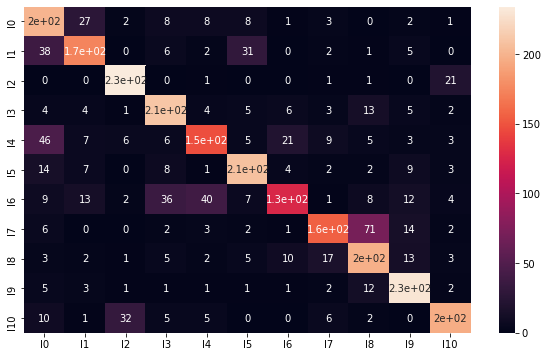

In [26]:

predict = m.predict(X_test)

y_test_true = to_categorical(y_test.argmax(1)).astype(np.int32)
y_test_pred = to_categorical(predict.argmax(1)).astype(np.int32)

auc = 100*roc_auc_score(y_test_true, y_test_pred, average='weighted', multi_class='ovo')
acc = 100*accuracy_score(y_test_true, y_test_pred,)

results = m.evaluate(X_train, y_train, batch_size=batch_size)
print("train loss: {},\ntrain acc: {}".format(results[0], results[1]))
results = m.evaluate(X_valid, y_valid, batch_size=batch_size)
print("val loss: {},\nval acc: {}".format(results[0], results[1]))
results = m.evaluate(X_test, y_test, batch_size=batch_size)
print("test loss: {},\ntest acc: {}".format(results[0], results[1]))
prec, rec, f1, _ = precision_recall_fscore_support(y_test_true, y_test_pred, average='weighted')
print('Test accuracy: {:.5f}, AUC {:.5f}, Precision {:.5f}, Recall {:.5f}, F1 {:.5f}, \n'.format( acc, auc, prec, rec, f1))
# print('Train accuracy: {:.2f}%'.format(100*accuracy))
cm = confusion_matrix(y_test.argmax(axis=1), predict.argmax(axis=1), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(cm)

index = ['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'l8', 'l9', 'l10']  
columns = ['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'l8', 'l9', 'l10']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [25]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 80, 1024, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 1022, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 511, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 509, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 254, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 252, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 126, 128)       0